# Modules

The steps:

1. Calculate 'true' SS19 net demand quantity.
2. Forecast SS19 true net demand with pre-SS19 data, using the methodologies of our previous delivery.
3. Forecast SS19 true net demand with pre-SS19 data, using the improved/current methodologies.
4. Evaluate the two approaches.

In [1]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = all

# from IPython.core.display import display, HTML
# display(HTML(<style>.container { width:100% !important; }</style>))


Loading BokehJS ...

## Kids jackets

In [2]:
kids_jackets = pd.read_excel('data/jackets_kids.xlsx', sheet_name='FW18 art list')

In [3]:
kids_jackets.head()

,Article Number,Article Desc,Product Type,AgeGroup,Sales Line,Business Unit,Business Segment
0,CF1605,YB SD BTS JKT,JACKET (DOWN),JUNIOR,JACKETS,BU YOUNG ATHLETES,TRAINING APP YOUNG ATHLETES ADIDAS
1,DH2687,J TRF SD JKT,JACKET (FILLED HEAVYWEIGHT),JUNIOR,ADICOLOR,BU ORIGINALS APP/ACC,ORIGINALS APP KIDS ADIDAS
2,DH2685,J TRF MS JKT,JACKET (FILLED THIN),JUNIOR,ADICOLOR,BU ORIGINALS APP/ACC,ORIGINALS APP KIDS ADIDAS
3,D96075,I TRF MS JACKET,JACKET (FILLED THIN),INFANT,ADICOLOR,BU ORIGINALS APP/ACC,ORIGINALS APP KIDS ADIDAS
4,CF1621,YG SD BTS JKT,JACKET (DOWN),JUNIOR,JACKETS,BU YOUNG ATHLETES,TRAINING APP YOUNG ATHLETES ADIDAS


# Data

In [4]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')
ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
                                  'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc'])



In [5]:
dat = dat0.copy().dropna()
dat = dat[(dat.season_net_qty > 100)].sort_values(['article_number', 'country', 'year', 'week'])



In [6]:
a = set(dat[dat.season == 'SS18'].article_number)
b = set(dat[dat.season == 'SS19'].article_number)

carryovers = a.intersection(b)
len(carryovers) 

1664

# Method 0

In [7]:
dat_m0 = dat[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'clearance', 'season_net_qty', 'buy_availability']].copy()

dat_m0 = pd.merge(
    pd.DataFrame(dat_m0.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum().reset_index()),
    pd.DataFrame(dat_m0.groupby(['article_number', 'season', 'year', 'week'])['buy_availability', 'clearance', 'season_net_qty'].mean().round(2).reset_index())
)

In [8]:
# adjust for clearance, as in original delivery
dat_m0['adj_net_qty'] = np.where(dat_m0.net_qty * (1 - dat_m0.clearance) > 0, dat_m0.net_qty * (1 - dat_m0.clearance), 0)

# remove low availability weeks, replace with avg of remaining
dat_m0 = pd.merge(
    dat_m0,
    pd.DataFrame(dat_m0[dat_m0.buy_availability > 0.35].groupby(['article_number', 'season'])['adj_net_qty'].mean().round(1)*26).rename(columns = {'adj_net_qty': 'adj_seas_net_qty'}).reset_index()
    )

dat_m0['adj_seas_net_qty'] = [max(x, y) for x, y in zip(dat_m0['season_net_qty'], dat_m0['adj_seas_net_qty'])] # max of original and adjusted; prevent adjusting down!

# Reduce to SS18, carryovers
dat_m0 = dat_m0[dat_m0.season == 'SS18'][['article_number', 'season', 'adj_seas_net_qty']].drop_duplicates()
dat_m0 = dat_m0[dat_m0.article_number.isin(carryovers)]

# Predict!!
dat_m0['DAA_m0'] = dat_m0.adj_seas_net_qty*1.1

In [9]:
mothership = dat_m0[['article_number', 'DAA_m0']].copy()

# Buyers

In [10]:
buyer_table = pd.read_csv('data/Buyers Predictions.csv', low_memory = False, sep = ",")
buyer_table = buyer_table[(buyer_table.season == 'SS19')]
buyer_table = buyer_table[['article', 'season', 'ecom_marketing_forecast']].rename(columns = {'article': 'article_number'})



In [11]:
mothership = pd.merge(
    mothership,
    buyer_table[['article_number', 'ecom_marketing_forecast']],
    how = 'left'
)


# GAS w/ buy_availability (only)

In [12]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m

    return loglik_res

def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 400, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, None),  # omega 
                (0.001, None),          # sigma
                (0.001, None)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        print('Convergence failure notification')
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 400, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, None),  # omega 
                    (0.001, None),          # sigma
                    (0.001, None)   # f
                   )
                )
        
        if abc.success == False:
            print('Unresolved convergence failure')

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

In [13]:
# dat0 = pd.read_csv('data/ch4k_df_eu.csv')

# ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, # index_col = 0, 
#                        error_bad_lines = False,
#                        usecols = ['article_no', 'model_no', 'art_desc', 
#                                   'key_cat_desc', 'sports_cat_desc', 'rmh_cat_desc', 
#                                   'franchise', 'franchise_family',
#                                   'prod_grp_desc', 'prod_type_desc']                      
#                       )

In [14]:
dat_GAS = dat0.copy()

dat_GAS = dat_GAS.dropna()
dat_GAS = dat_GAS[(dat_GAS.season_net_qty > 100) & (dat_GAS.season_net_qty != 0) & (dat_GAS.season == 'SS18')]

dat_GAS = dat_GAS[dat_GAS.article_number.isin(carryovers)] 
dat_GAS = dat_GAS[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'clearance', 'season_net_qty', 'buy_availability']]
dat_GAS = dat_GAS.sort_values(['article_number', 'country', 'year', 'week']).reset_index().drop('index', axis = 1)



In [15]:
# To punt on correcting EU/UK separately
dat_GAS = pd.merge(
    pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['net_qty'].sum()).reset_index(),
    pd.DataFrame(dat_GAS.groupby(['article_number', 'year', 'week'])['buy_availability'].mean()).reset_index()
)

In [16]:
%%time 

dat_GAS = dat_GAS.groupby(['article_number']).apply(GAS_est)
dat_GAS = dat_GAS.reset_index()


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in square
  
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in multiply
  
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: overflow encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Unresolved convergence failure
Convergence failure notification
Convergence failure notification
Convergence failure notification
Unresolved convergence failure
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
Convergence failure notification
CPU times: user 8min 49s, sys: 4.01 s, total: 8min 53s
Wall time: 8min 51s


In [17]:
mothership = pd.merge(
    mothership,
    pd.DataFrame(dat_GAS.groupby(['article_number'])['GAS_est'].apply(sum).round(2)*1.32).reset_index()
)


# Rolling Window

In [19]:
dat_roll = dat0.copy()

dat_roll = dat_roll.dropna()
dat_roll = dat_roll[(dat_roll.season_net_qty > 100) & (dat_roll.season_net_qty != 0) & (dat_roll.season == 'SS18')]

dat_roll = dat_roll[dat_roll.article_number.isin(carryovers)] 
dat_roll = dat_roll[['article_number', 'year', 'week', 'country', 'season', 'net_qty', 'clearance', 'season_net_qty', 'buy_availability']]
dat_roll = dat_roll.sort_values(['article_number', 'country', 'year', 'week']).reset_index().drop('index', axis = 1)

# Function
def roll(df):
    ret = pd.DataFrame(df.buy_availability.rolling(window = 3, min_periods = 1).mean())
    return ret

# Smooth buy_availability
dat_roll['buy_availability'] = round(dat_roll.groupby(['article_number', 'country']).apply(roll), 2)

# UK + EU: add net_qty, avg buy_availability
dat_roll = pd.merge(
    pd.DataFrame(dat_roll.groupby(['article_number', 'year', 'week'])['net_qty'].sum()).reset_index(),
    pd.DataFrame(dat_roll.groupby(['article_number', 'year', 'week'])['buy_availability'].mean()).reset_index()
)

# Adjusted net_qty
dat_roll['roll_est'] = dat_roll.net_qty / dat_roll.buy_availability

mothership = pd.merge(
    mothership,
    pd.DataFrame(dat_roll.groupby(['article_number'])['roll_est'].apply(sum).round(2)*1.32).reset_index()
)

## Seasonality: category-level memberships

In [20]:
# dat0 = pd.read_csv('data/ch4k_df_eu.csv')
# ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False, 
#                        usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 
#                                   'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc'])


In [22]:
dat.head()
seasonality_dat.head()

,article_number,brand,year,week,country,season,season_year,gross_demand_quantity,net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,model_no,art_desc,sports_cat_desc_x,rmh_cat_desc_x,franchise_x,gender_desc_x,age_group_desc_x,prod_grp_desc_x,prod_type_desc,cost,price,article_no,sports_cat_desc_y,rmh_cat_desc_y,gender_desc_y,age_group_desc_y,franchise_y,prod_grp_desc_y
15497,015110,adidas,2016,49,EU,SS17,2017,5,5,0.0,65.21,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.93,98.14,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15543,015110,adidas,2016,49,UK,SS17,2017,5,5,0.0,65.21,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.93,98.14,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15545,015110,adidas,2016,50,EU,SS17,2017,21,12,0.0,71.45,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.37,103.82,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15548,015110,adidas,2016,50,UK,SS17,2017,13,13,0.0,71.45,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.37,103.82,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15563,015110,adidas,2016,51,UK,SS17,2017,13,12,0.0,70.71,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.28,102.99,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES


,article_number,brand,year,week,country,season,season_year,gross_demand_quantity,net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,model_no,art_desc,sports_cat_desc_x,rmh_cat_desc_x,franchise_x,gender_desc_x,age_group_desc_x,prod_grp_desc_x,prod_type_desc,cost,price,article_no,sports_cat_desc_y,rmh_cat_desc_y,gender_desc_y,age_group_desc_y,franchise_y,prod_grp_desc_y
15497,015110,adidas,2016,49,EU,SS17,2017,5,5,0.0,65.21,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.93,98.14,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15543,015110,adidas,2016,49,UK,SS17,2017,5,5,0.0,65.21,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.93,98.14,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15545,015110,adidas,2016,50,EU,SS17,2017,21,12,0.0,71.45,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.37,103.82,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15548,015110,adidas,2016,50,UK,SS17,2017,13,13,0.0,71.45,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.37,103.82,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES
15563,015110,adidas,2016,51,UK,SS17,2017,13,12,0.0,70.71,649,507,0.0,10034,COPA MUNDIAL,FOOTBALL/SOCCER,FOOTBALL GENERIC,NOT APPLICABLE,MEN,ADULT,SHOES,FOOTBALL SHOES (FIRM GROUND),32.28,102.99,015110,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,ADULT,NOT APPLICABLE,SHOES


In [23]:
dat = dat0.copy()
# ref_dat = ref_dat0.copy()

dat = dat.dropna()
dat = dat[(dat.season_net_qty > 100) & (dat.season.isin(['SS17', 'SS18']))].sort_values(['article_number', 'year', 'week'])

# For constructing seasonality reference by product_type
# ref_dat = ref_dat[['article_no', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates() 
# dat = pd.merge(dat, ref_dat, left_on='article_number', right_on='article_no', how = 'left').sort_values(['article_number', 'year', 'week'])

# ---- All-seasons cat-level means ----
seasonality_dat = dat.copy()
seasonality_dat = pd.merge(
    pd.DataFrame(seasonality_dat.groupby(['article_number', 'season', 'year', 'week'])['net_qty'].sum()).reset_index(),
    seasonality_dat[['article_number', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']].drop_duplicates()
).dropna()

# seasonality_dat[seasonality_dat.isna().any(axis=1)]


In [24]:
seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]

In [25]:
# ---- SS18 seasonality (cat-level means) ----
seasonality_dat_SS18 = seasonality_dat[seasonality_dat.season == 'SS18']

seasonality_sport_SS18   = pd.DataFrame(seasonality_dat_SS18.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean_SS18'})
seasonality_rmh_SS18     = pd.DataFrame(seasonality_dat_SS18.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean_SS18'})
seasonality_gndr_SS18    = pd.DataFrame(seasonality_dat_SS18.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean_SS18'})
seasonality_agegrp_SS18  = pd.DataFrame(seasonality_dat_SS18.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean_SS18'})
seasonality_frnchse_SS18 = pd.DataFrame(seasonality_dat_SS18.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean_SS18'})
seasonality_prdgrp_SS18 = pd.DataFrame(seasonality_dat_SS18.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean_SS18'})

seasonality_dfs_SS18 = [seasonality_sport_SS18, seasonality_rmh_SS18, seasonality_gndr_SS18, seasonality_agegrp_SS18, seasonality_frnchse_SS18, seasonality_prdgrp_SS18]



In [26]:
# ---- SS18-SS19 carryovers: SS18 data ----
carryovers_SS18 = (seasonality_dat[(seasonality_dat.season == 'SS18') & 
                                   (seasonality_dat.article_number.isin(carryovers))
                                 ].
                   rename(columns = {'net_qty': 'article_net_qty'}).
                   sort_values(['article_number', 'season', 'year', 'week'])
                  )

In [ ]:
# Add all-season mean column to SS18 df --- to calculate SS19 deseas

# net_qty_cols = ['sport_weekly_mean', 'rmh_weekly_mean', 'gender_weekly_mean', 'age_weekly_mean', 'franchise_weekly_mean', 'prd_grp_weekly_mean'] # seasonality_df[<net_qty_by_another_name>] 
# abbrevs = ['sp', 'rmh', 'gndr', 'age', 'frnchse', 'prd_grp']

# for i in range(6):
#     seasonality_dfs_SS18[i] = pd.DataFrame(pd.merge(seasonality_dfs[i], seasonality_dfs_SS18[i]))
#     seasonality_dfs_SS18[i][abbrevs[i] + '_deseas'] = seasonality_dfs_SS18[i].loc[:, net_qty_cols[i] + '_SS18'] - seasonality_dfs_SS18[i].loc[:, net_qty_cols[i]]
    
    

In [27]:
def regress(df):
    # function for regressing article net_qty on seasonalities
    # for article a's level of each category, retreive weekly means, then regress 

#     print(df.columns)
#     print(df.iloc[:5,:5])
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
    
    # article net_demand_qty
    y = df[['article_net_qty', 'week']].set_index('week')

    # article category-level combination weekly means
    # set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True).
          merge(x_rmh, left_index=True, right_index=True).
          merge(x_gndr, left_index=True, right_index=True).
          merge(x_agegrp, left_index=True, right_index=True).
          merge(x_frnchse, left_index=True, right_index=True).
          merge(x_prdgrp, left_index=True, right_index=True).
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities
    # print(df.article_number.unique())
    
    mod = sm.OLS(yX.article_net_qty, yX.drop('article_net_qty', axis = 1), missing='drop').fit()
#     print(df.article_number.unique())
#     print(round(mod.rsquared, 2))
#     print()
    
    ret['seas_preds'] = mod.predict()
    ret['deseas_net_qty'] = df['article_net_qty'] - ret['seas_preds']

    return ret




def initialize_parameters_0(par = np.array([0.5, 0.9, 0, 1, 0])):
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   

    return parameters


def loglik_0(y, f, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - f)**2 
    return ll


def score_compute_0(y, f, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - f)/sigma
    
    return score


def filterGAS_0(y, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score0 = score_compute_0(y[0,:],  f0, parameters, epsilon = 1e-7) 
    
    f = np.zeros((len(y),1))
    f[0,:] = f0
    
    for t in range(1,len(y)):
        scoret = score_compute_0(y[t-1,:], f[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f


def loglikest_0(par, y):
    
    parameters = initialize_parameters_0(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    
    f = filterGAS_0(y, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik_0(y[t,:], f[t,:], sigma)
            
    loglik_res = -(np.sum(ll))/m

    return loglik_res


def GAS_est_0(df, col):
    
    y = df.loc[:, col].values 
    y = y.reshape((len(y),1)) 
    
    ret = pd.DataFrame()
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest_0,                                       
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), 
        args = y, 
        options = {'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method ='L-BFGS-B', 
        bounds =((0,  None),    # alpha
                (-1, 1),        # beta
                (0.001, None),  # omega 
                (0.001, None),  # sigma
                (0.001, None)   # f
               )
    )
    
    if abc.success == False:
        print('C1 failed for article', abc.message)

    x1par = initialize_parameters_0(abc.x) 
    GAS = filterGAS_0(y, x1par)
    ret['GAS_est'] = GAS
    
    return ret     

In [28]:
# **** Try regression with 'rolling' corrected net_qty  ****

carryovers_SS18 = pd.merge(
    carryovers_SS18,
    dat_roll.drop(['net_qty', 'buy_availability'], axis = 1)
).drop('article_net_qty', axis = 1).rename(columns = {'roll_est': 'article_net_qty'})

carryovers_SS18 = pd.merge(
    carryovers_SS18,
    carryovers_SS18.groupby(['article_number']).apply(regress).reset_index().drop('level_1', axis = 1)
)


In [29]:
mothership = pd.merge(
    mothership,
    pd.DataFrame(carryovers_SS18.groupby(['article_number'])['seas_preds'].apply(sum).round(2)*1.32).reset_index()
)

# 'seas_preds': 
    # (1) rolling window avg. of buy availability
    # (2) use (1) to calculate corrected net_qty
    # (3) regress this *corrected* net_qty on cat-level seasonalities
    # (4) Use these fitted values as 'true'
    # (5) Aggregate over season, multiply by 1.32 (growth and buffer)

In [30]:
# %%time 

# categories =  ['sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise',      'prod_grp_desc']
# deseas_cols = ['sp_deseas',       'rmh_deseas',   'gndr_deseas', 'age_deseas',     'frnchse_deseas', 'prd_grp_deseas'] # seasonality_df[<net_qty_by_another_name>] 
# abbrevs =     ['sp',              'rmh',          'gndr',        'agegrp',         'frnchse',        'prdgrp']

# for i in range(6):
#     seasonality_dfs_SS18[i] = pd.DataFrame(pd.merge(
#         seasonality_dfs_SS18[i], 
#         seasonality_dfs_SS18[i].groupby(categories[i]).apply(GAS_est_0, col = deseas_cols[i]).reset_index().drop('level_1', axis = 1)
#     )).rename(columns = {'GAS_est': 'GAS_est_' + abbrevs[i] + '_deseas'}) # distinct names for GAS_est column
  

# def initialize_parameters_mv(par = np.array([0.5, 0.9, 0, 1, 0, 0, 0, 0, 0, 0, 0])):
#     parameters = {}

#     parameters['alpha'] = par[0]
#     parameters['beta'] = par[1]
#     parameters['omega'] = par[2]* (1-par[1])
#     parameters['sigma'] = par[3]
#     parameters['f0'] = par[4]
    
#     # l for lambda
#     parameters['l_sport'] = par[5]
#     parameters['l_rmh'] = par[6]    
#     parameters['l_gender'] = par[7]
#     parameters['l_age'] = par[8]
#     parameters['l_franchise'] = par[9]
#     parameters['l_prod_grp'] = par[10]
    
#     return parameters


# def loglik_mv(y, f, 
#               f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, 
#               l_sport, l_rmh, l_gender, l_age, l_franchise, l_prod_grp, 
#               sigma):
    
#     ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - (f + l_sport*f_sp + l_rmh*f_rmh + l_gender*f_gndr + l_age*f_age + l_franchise*f_fr + l_prod_grp*f_pr))**2 
    
#     return ll


# def score_compute_mv(y, f, 
#                      f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, 
#                      parameters, epsilon = 1e-7):
          
#     alpha = parameters["alpha"]
#     beta = parameters["beta"]
#     omega = parameters['omega']
#     sigma = parameters["sigma"]
#     f0 = parameters["f0"]
          
#     l_sport = parameters['l_sport'] 
#     l_rmh = parameters['l_rmh'] 
#     l_gender = parameters['l_gender'] 
#     l_age = parameters['l_age'] 
#     l_franchise = parameters['l_franchise'] 
#     l_prod_grp = parameters['l_prod_grp']
    
#     score = (y - (f + l_sport*f_sp + l_rmh*f_rmh + l_gender*f_gndr + l_age*f_age + l_franchise*f_fr + l_prod_grp*f_pr))/sigma
    
#     return score


# def filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters):
    
#     alpha = parameters["alpha"]
#     beta = parameters["beta"]
#     omega = parameters['omega']
#     sigma = parameters["sigma"]
#     f0 = parameters["f0"]
          
#     l_sport = parameters['l_sport'] 
#     l_rmh = parameters['l_rmh'] 
#     l_gender = parameters['l_gender'] 
#     l_age = parameters['l_age'] 
#     l_franchise = parameters['l_franchise'] 
#     l_prod_grp = parameters['l_prod_grp']
    
#     # print('filterGAS_mv:', y.shape)
    
#     score0 = score_compute_mv(y[0,:], f0, f_sp[0,:], f_rmh[0,:], f_gndr[0,:], f_age[0,:], f_fr[0,:], f_pr[0,:], parameters, epsilon = 1e-7) 
    
#     f = np.zeros((len(y), 1))
#     f[0,:] = f0
    
#     for t in range(1,len(y)):
#         scoret = score_compute_mv(y[t-1,:], f[t-1,:], f_sp[t-1,:], f_rmh[t-1,:], f_gndr[t-1,:], f_age[t-1,:], f_fr[t-1,:], f_pr[t-1,:], parameters, epsilon = 1e-7) 
#         f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

#     return f


# def loglikest_mv(parameters, y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr):
    
#     parameters = initialize_parameters_mv(parameters)
          
#     alpha = parameters["alpha"]
#     beta = parameters["beta"]
#     sigma = parameters["sigma"]
          
#     l_sport = parameters['l_sport'] 
#     l_rmh = parameters['l_rmh'] 
#     l_gender = parameters['l_gender'] 
#     l_age = parameters['l_age'] 
#     l_franchise = parameters['l_franchise'] 
#     l_prod_grp = parameters['l_prod_grp']
          
#     ll = np.zeros((len(y), 1))
#     m = len(y)
    
#     if len(y.shape) == 1:
#         y = y.reshape(len(y), 1)
        
#     f = filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters) 
          
#     for t in range(0, len(y)):
#          ll[t,:] = loglik_mv(y[t,:], f[t,:], 
#                              f_sp[t,:], f_rmh[t,:], f_gndr[t,:], f_age[t,:], f_fr[t,:], f_pr[t,:], 
#                              l_sport, l_rmh, l_gender, l_age, l_franchise, l_prod_grp, 
#                              sigma)
            
#     loglik_res = -(np.sum(ll))/m

#     return loglik_res

# # GAS behemoth

# def GAS_est_mv(df):
    
#     # For article a's level of each category 
#         # Retrieve deseasonalized y*
#         # Retreive appropriate GAS factors
#         # Then apply multi-factor GAS 
            
#     ret = pd.DataFrame()
#     ret['week'] = df['week']
    
#     y = df.deseas_net_qty.values     
#     y = y.reshape(len(y), 1) 
        
#     f_sp = df.GAS_est_sp_deseas.values.reshape((len(y),1)) 
#     f_rmh = df.GAS_est_rmh_deseas.values.reshape((len(y),1)) 
#     f_gndr = df.GAS_est_gndr_deseas.values.reshape((len(y),1)) 
#     f_age = df.GAS_est_agegrp_deseas.values.reshape((len(y),1)) 
#     f_fr = df.GAS_est_frnchse_deseas.values.reshape((len(y),1)) 
#     f_pr = df.GAS_est_prdgrp_deseas.values.reshape((len(y),1)) 
    
#     abc = scipy.optimize.minimize(
#         loglikest_mv,                                       
#         np.array([0.8, 0.9, np.mean(y), 1, np.mean(y), 0, 0, 0, 0, 0, 0]), 
#         args = (y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr),
#         options = {'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
#         method ='L-BFGS-B', 
#         bounds =(
#                 (0,  None),             # alpha
#                 (-1, 1),                # beta
#                 (0.001, None),          # omega 
#                 (0.001, None),          # sigma
#                 (0.001, None),          # f
#                 (None, None),           # lambda_sport
#                 (None, None),           # lambda_rmh
#                 (None, None),           # lambda_gender
#                 (None, None),           # lambda_age
#                 (None, None),           # lambda_franchise
#                 (None, None)            # lambda_prod_grp
#                )
#     )
      
#     # --- CONVERGENCE check message ---
#     if abc.success == False:
#         print('Convergence failed', abc.message)
#         print('Article:', df.article_number.unique()[0])
#         print()

#     x1par = initialize_parameters_mv(abc.x) 
#     GAS = filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, x1par)
#     ret['deseas_GAS_est'] = GAS

#     return ret

# # ---- create df for next GAS-ing ----
# for i in range(6):
#     if i == 0:
#         dat_factors = pd.merge(carryovers_SS18, seasonality_dfs_SS18[i], how = 'left')
#     else:
#         dat_factors = pd.merge(dat_factors, seasonality_dfs_SS18[i], how = 'left')
    
    

# # dat_factors.columns
# dat_factors = dat_factors[['article_number', 'year', 'week', 'season', 
#             'deseas_net_qty', 
#             'GAS_est_sp_deseas', 'GAS_est_rmh_deseas', 'GAS_est_gndr_deseas', 
#             'GAS_est_agegrp_deseas', 'GAS_est_frnchse_deseas', 'GAS_est_prdgrp_deseas']]

# a = np.random.choice(dat_factors.article_number.unique(), size = 50, replace = False)
# dat_factors_subset = dat_factors[dat_factors.article_number.isin(a)]

# %%time

# # 10 = 1 min
# # 20 = 1 min 20s
# # 50 = 2 min 45s

# dat_factors_subset
# dat_factors_subset = pd.DataFrame(pd.merge(
#         dat_factors_subset, 
#         dat_factors_subset.groupby('article_number').apply(GAS_est_mv).reset_index().drop('level_1', axis = 1)
#     ))

# dat_factors_subset.shape
# dat_factors_subset.head()

# # y_est = seas + deseas = 
# #       = carryover_SS18['seas_preds'] + dat_factors['deseas_GAS_est']

# carryovers_SS18 = pd.merge(
#     carryovers_SS18,
#     dat_factors_subset[['article_number', 'season', 'year', 'week', 'deseas_GAS_est']]
# )

# pd.merge(
#     mothership,
#     pd.DataFrame(carryovers_SS18.groupby('article_number')['seas_preds'].apply(sum)*1.1).reset_index()
# )

# carryovers_SS18['net_qty_est'] = carryovers_SS18.seas_preds + y_star.y_star 
# # y^* = f + lambda1*f_s1 + lambda2*f_s2 + ... + f_s5
# # y_hat = y_hat_seas + y_star

# # OLS to reverse engineer coefficients and predict!!

# # Combine into one df for regression trick
# dat_factors2 = pd.merge(
#     dat_factors,
#     carryovers_SS18[['article_number', 'season', 'year', 'week', 'deseas_GAS_est']]
# )

# # recreate coefficients, predict
# def regress2(df):
#     ret = pd.DataFrame()
#     ret['week'] = df.week

#     ret['y_star'] = sm.OLS(df.deseas_net_qty, 
#            df[['deseas_GAS_est', 
#                'GAS_est_sp_deseas', 'GAS_est_rmh_deseas', 'GAS_est_gndr_deseas', 
#                'GAS_est_agegrp_deseas', 'GAS_est_frnchse_deseas', 'GAS_est_prdgrp_deseas']]
#           ).fit().predict().round(2)
    
#     return ret

# # true-er deseasonalized 
# y_star = pd.DataFrame(dat_factors2.groupby('article_number').
#                       apply(regress2).
#                       reset_index()).drop('level_1', axis = 1)

# carryovers_SS18 = pd.merge(carryovers_SS18, y_star)

# # seasonal component + true-er deseasonalized component
# carryovers_SS18['y_est'] = carryovers_SS18.seas_preds + carryovers_SS18.y_star

# pd.merge(
#     mothership,
#     pd.DataFrame(carryovers_SS18.groupby('article_number')['y_est'].sum()*1.1).reset_index()
# )


## Cost and Price

In [31]:
dat_SS19 = dat0.copy().dropna()
dat_SS19 = dat_SS19[(dat_SS19.season_net_qty > 100) & (dat_SS19.season == 'SS19')]

# Add price and cost for profit calculations
mothership = pd.merge(
    mothership,
    pd.DataFrame(dat_SS19.groupby('article_number')['cost', 'price'].mean().round(2).reset_index())
)


## Actuals

In [32]:
# Conservative correction of SS19 net_qty

dat_SS19 = dat_SS19.sort_values(['article_number', 'country', 'year', 'week'])

def roll(df):
    ret = pd.DataFrame(df.buy_availability.rolling(window = 3, min_periods = 1).mean())
    return ret

dat_SS19['buy_availability'] = round(dat_SS19.groupby(['article_number', 'country']).apply(roll), 2)
dat_SS19['buy_availability'] = [max(0.15, x) for x in dat_SS19.buy_availability]

dat_SS19['corrected_SS19_net_qty'] = dat_SS19.net_qty / dat_SS19.buy_availability

mothership = pd.merge(
    mothership,
    pd.DataFrame(dat_SS19.groupby('article_number')['corrected_SS19_net_qty'].apply(sum).round()).reset_index()
)

## Crystal Ball

In [33]:

# Assuming perfect forecast, + 20% buffer
mothership['crystal_ball'] = mothership.corrected_SS19_net_qty*1.2


## Results

In [ ]:
# mothership.query('GAS_est/corrected_SS19_net_qty > 8').shape
# mothership.query('GAS_est/corrected_SS19_net_qty > 8')


In [ ]:
# Filter on: vanilla_forecast < 7 * corrected_net
mothership.shape
mothership = mothership[(mothership.roll_est < 7 * mothership.corrected_SS19_net_qty) & (abs(mothership.roll_est - mothership.corrected_SS19_net_qty) < 15000)]
mothership.shape


In [ ]:
mothership['roll_est'] = mothership.roll_est * (1.32/2)

In [ ]:
plt.hist(x, bins = 100, range = (-2000, 2000))

In [ ]:
res = pd.DataFrame()

res['article_number'] = mothership.article_number
res['m0_MAPE']    = round(abs(mothership.DAA_m0      - mothership.corrected_SS19_net_qty)/mothership.corrected_SS19_net_qty * 100)
res['roll_MAPE']  = round(abs(mothership.roll_est    - mothership.corrected_SS19_net_qty)/mothership.corrected_SS19_net_qty * 100)
# res['GAS_MAPE']   = round(abs(mothership.GAS_est     - mothership.corrected_SS19_net_qty)/mothership.corrected_SS19_net_qty * 100)
res['preds_MAPE'] = round(abs(mothership.seas_preds  - mothership.corrected_SS19_net_qty)/mothership.corrected_SS19_net_qty * 100)
res.describe().round(0).iloc[[1, 2, 5]]

In [ ]:

res['rev_m0']      = np.where(mothership.DAA_m0   < mothership.corrected_SS19_net_qty, mothership.DAA_m0  *mothership.price, mothership.corrected_SS19_net_qty*mothership.price)
res['rev_roll']    = np.where(mothership.roll_est < mothership.corrected_SS19_net_qty, mothership.roll_est*mothership.price, mothership.corrected_SS19_net_qty*mothership.price)
res['rev_preds']   = np.where(mothership.seas_preds  < mothership.corrected_SS19_net_qty, mothership.seas_preds*mothership.price, mothership.corrected_SS19_net_qty*mothership.price)
# res['rev_eCom']  = np.where(mothership.ecom_marketing_forecast  < mothership.corrected_SS19_net_qty, mothership.ecom_marketing_forecast*mothership.price, mothership.corrected_SS19_net_qty*mothership.price)
res['rev_crystal_ball'] = mothership.corrected_SS19_net_qty*mothership.price

res['cost_m0']     = mothership.DAA_m0     * mothership.cost
res['cost_roll']   = mothership.roll_est   * mothership.cost
res['cost_preds']  = mothership.seas_preds * mothership.cost
# res['cost_eCom'] = mothership.ecom_marketing_forecast * mothership.cost
res['cost_crystal_ball'] = mothership.crystal_ball * mothership.cost

res['profit_m0']      = res.rev_m0     - res.cost_m0
res['profit_roll']    = res.rev_roll   - res.cost_roll
res['profit_preds']   = res.rev_preds  - res.cost_preds
# res['profit_eCom']  = res.rev_eCom - res.cost_eCom
res['profit_crystal_ball'] = res.rev_crystal_ball - res.cost_crystal_ball


In [ ]:
mil = 1000000
res[['profit_m0', 'profit_roll', 'profit_preds', 'profit_crystal_ball']].apply('sum')/mil

round(29.082 - 28.555, 3)

In [36]:
mothership['final_answer'] = (mothership.seas_preds + mothership.GAS_est)/2

In [37]:
mothership.head()

,article_number,DAA_m0,ecom_marketing_forecast,GAS_est,roll_est,seas_preds,cost,price,corrected_SS19_net_qty,crystal_ball,final_answer
0,015110,510.40,800.0,731.4384,702.1608,681.4896,34.34,109.27,782.0,938.4,706.4640
1,019000,1415.70,2000.0,1699.1964,1698.8400,1671.6876,15.64,53.58,1244.0,1492.8,1685.4420
2,019099,1178.32,NaN,3188.9088,2968.8780,2779.9992,12.39,30.93,1167.0,1400.4,2984.4540
3,019228,420.42,500.0,633.9564,602.5272,587.5452,20.56,96.85,515.0,618.0,610.7508
4,019310,255.20,500.0,322.3440,306.7416,310.0152,19.92,98.26,279.0,334.8,316.1796


## Optimal Overbuy

f_bins
(0, 125]       1596.496678
(125, 250]      370.254660
(250, 375]      526.144684
(375, 500]      610.540910
(500, 625]      612.787403
(625, 750]      595.492064
(750, 875]     1285.083387
(875, 1000]     352.909870
Name: e, dtype: float64

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      e   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     7.483
Date:                Wed, 18 Sep 2019   Prob (F-statistic):             0.0291
Time:                        14:48:57   Log-Likelihood:                -62.448
No. Observations:                   8   AIC:                             126.9
Df Residuals:                       7   BIC:                             127.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9731      0.356      2.735      0.029       0.132       1.814
==============================================================================
Omnibus:                        6.820   Durbin-Watson:                   1.164
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                1.847
Skew:                           1.074   Prob(JB):                        0.397
Kurtosis:                       3.962   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

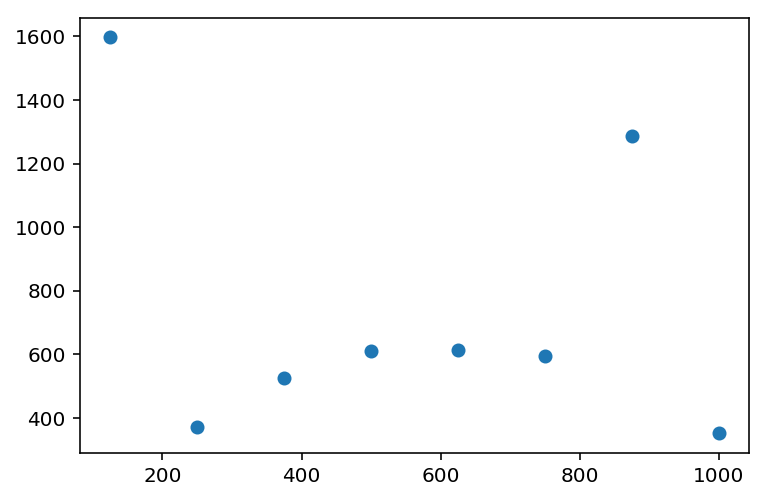

In [71]:
df = pd.DataFrame()
df['f'] = mothership.final_answer
df['e'] = abs(mothership.final_answer - mothership.corrected_SS19_net_qty)
# x.mean()
# x.std()
# x.describe()

b = np.array([0, 125, 250, 375, 500, 625, 750, 875, 1000])

df['f_bins'] = pd.cut(df.f, bins = b)
df['e_bins'] = pd.cut(df.e, bins = b)

y = df.groupby('f_bins')['e'].agg(np.std)
y

plt.scatter(b[1:], df.groupby('f_bins')['e'].agg(np.std))

# response, predictor
# error sd, forecast
X = b[1:]
# X = sm.add_constant(X)
sd_pred = sm.OLS(y, X).fit()
sd_pred.summary()

f_bins
(0, 250]          668.301439
(250, 500]        556.838136
(500, 1000]       784.095833
(1000, 2500]      997.810106
(2500, 5000]     2798.882963
(5000, 10000]    2576.677860
Name: e, dtype: float64

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      e   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     12.53
Date:                Wed, 18 Sep 2019   Prob (F-statistic):             0.0240
Time:                        14:27:42   Log-Likelihood:                -45.233
No. Observations:                   6   AIC:                             94.47
Df Residuals:                       4   BIC:                             94.05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        645.2895    311.146      2.074      0.107    -218.591    1509.170
x1             0.2343      0.066      3.540      0.024       0.051       0.418
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.804
Prob(Omnibus):                    nan   Jarque-Bera (JB):                2.435
Skew:                           1.514   Prob(JB):                        0.296
Kurtosis:                       3.753   Cond. No.                     6.43e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

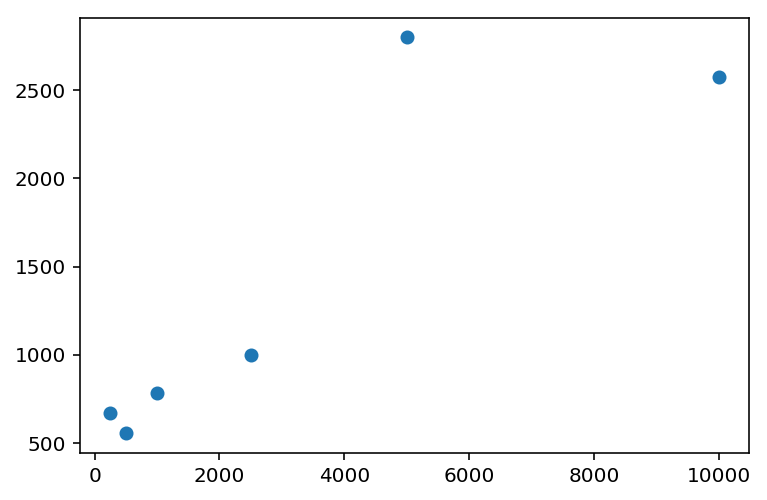

In [34]:

df = pd.DataFrame()
df['f'] = mothership.final_answer
df['e'] = abs(mothership.final_answer - mothership.corrected_SS19_net_qty)
# x.mean()
# x.std()
# x.describe()

df['f_bins'] = pd.cut(df.f, bins = np.array([0, 250, 500, 1000, 2500, 5000, 10000]))
df['e_bins'] = pd.cut(df.e, bins = np.array([0, 250, 500, 1000, 2500, 5000, 10000]))

df.groupby('f_bins')['e'].agg(np.std)

plt.scatter([250, 500, 1000, 2500, 5000, 10000], df.groupby('f_bins')['e'].agg(np.std))

# response, predictor
# error sd, forecast
X = [250, 500, 1000, 2500, 5000, 10000]
X = sm.add_constant(X)
sd_pred = sm.OLS(df.groupby('f_bins')['e'].agg(np.std), X).fit()
sd_pred.summary()

In [ ]:
from functools import partial
from scipy import optimize
from scipy import integrate
import scipy.stats as stats

# Loss --- demand, buy, margin, cost
def L(d, b, margin, cost):
    if d > b:
        return (d - b)*margin
    elif d < b:
        return (b - d)*cost
    elif d == b:
        return 0
    else:
        print('Error')

# E[L | buy, article_mean, article_sd, article_margin, article_cost]
def EL(mu, sigma, margin, cost, b):
    I = lambda x: L(x, b, margin, cost) * stats.norm.pdf(x, mu, sigma) # I for integrand
    Exp_loss = integrate.quad(I, 0, mu + 3*sigma)
    return round(Exp_loss[0], 2) 

def minimize_EL(mu, sigma, margin, cost):
    p = partial(EL, mu, sigma, margin, cost) # Make EL function of only one var: b_0
    buy_opt = optimize.minimize_scalar(p, bounds = (mu - 0.5*sigma, mu + 2*sigma))
    return int(buy_opt['x']) # optimal buy quantity

In [ ]:
%%time

mothership['CB_w_opt_overbuy'] = mothership.apply(lambda row: minimize_EL(row['corrected_SS19_net_qty'], 0.1*row['corrected_SS19_net_qty'], row['margin'], row['cost']), axis=1)



In [ ]:
mothership['roll_est_sd'] = sd_pred.predict(sm.add_constant(mothership.roll_est))
mothership.head()

In [ ]:
%%time

mothership['roll_w_opt_overbuy'] = mothership.apply(lambda row: minimize_EL(row['roll_est'], row['roll_est_sd'], row['price'] - row['cost'], row['cost']), axis=1)



In [ ]:
res['rev_roll_opt'] = np.where(mothership.roll_w_opt_overbuy < mothership.corrected_SS19_net_qty, 
                               mothership.roll_w_opt_overbuy    *mothership.price, 
                               mothership.corrected_SS19_net_qty*mothership.price)

res['cost_roll_opt'] = mothership.roll_w_opt_overbuy * mothership.cost
res['profit_roll_opt'] = res.rev_roll_opt - res.cost_roll_opt



In [ ]:
res[['profit_m0', 'profit_roll', 'profit_crystal_ball', 'profit_roll_opt']].apply('sum')/mil

In [ ]:
plt.scatter(res.profit_roll_opt, res.profit_crystal_ball)

# res[['profit_m0', 'profit_roll', 'profit_preds', 'profit_crystal_ball', 'profit_roll_opt']].sort_values('profit_crystal_ball', ascending = False)/mil # .iloc[249]



## Appendix

In [ ]:
# dat_SS18 = dat[dat.season == 'SS18'].copy().rename(columns = {'net_qty': 'article_net_qty'}).drop(['clearance', 'margin', 'gross_demand_quantity', 'season_gross_demand_quantity'], axis = 1)

# # ---- For development select subset of articles ----
# articles = dat_SS18.article_number.unique()
# articles_subset = np.random.choice(articles, size = 5, replace = False)

# dat_SS18 = dat_SS18[dat_SS18.article_number.isin(articles_subset)]



In [ ]:
# a = np.random.choice(articles_subset, size = 1, replace = False)
# dat_SS18[dat_SS18.article_number == a[0]][['article_net_qty', 'seas_preds']].plot(linewidth = 3)

In [ ]:
# For sorting
# key = {'FW16': 1, 'SS17': 2, 'FW17': 3, 'SS18': 4, 'FW18': 5, 'SS19': 6, 'FW19': 7, 'SS20': 8}
# dat['order_key'] = [key[s] for s in dat.season]

In [ ]:
# # Stan Smith: Prediction, E[L] minimizing buy, comparison 

# mu = 38000
# sigma = 7000
# margin = 65.80
# cost = 4.20

# # buys = list(range(mu - 1*sigma, mu + 3*sigma, 50)) # buy qtys for which calculate E[L]
# # ELs = [EL(b, mu, sigma, margin, cost) for b in buys]

# b_0 = minimize_EL(mu, sigma, margin, cost)
# l_0 = EL(mu, sigma, margin, cost, b_0)

# print('Buying', b_0, 'units minimizes expected loss') # buy qty that minimizes expected loss
# print()
# print('Minimized expected loss:', l_0) # minimized Expected loss
# print()
# print('Expected loss with 20% buffer approach:', EL(38000, 7000, 65.80, 4.2, 38000*1.2))
# print()
# print('Expected profit increase:', l_0 - EL(38000, 7000, 65.80, 4.2, 38000*1.2), 2)

# # Expected loss against function of buy qty
# plt.rcParams["figure.figsize"] = [12,8]

# buys = np.linspace(mu - 3.5*sigma, mu + 3.5*sigma, 100)
# ELs = [EL(mu, sigma, margin, cost, b) for b in buys]

# plt.plot(buys, ELs, linewidth = 3)

# plt.title('Expected Loss vs. Buy Quantity', size = 18)
# plt.xlabel('Buy Quantity', size = 18)
# plt.ylabel('Expected Loss', size = 18)

# minimize_EL(mu, sigma, margin, cost)

In [ ]:
# dat_SS18 = dat0.copy().dropna()
# dat_SS18 = dat_SS18[(dat_SS18.season_net_qty > 100) & (dat_SS18.season == 'SS18')]

# dat_SS18 = dat_SS18.sort_values(['article_number', 'country', 'year', 'week'])

# dat_SS18['buy_availability_2'] = round(dat_SS18.groupby(['article_number', 'country']).apply(roll), 2)
# dat_SS18['buy_availability_2'] = [max(0.15, x) for x in dat_SS18.buy_availability_2]

# dat_SS18['corrected_SS18_net_qty_x11'] = dat_SS18.net_qty / dat_SS18.buy_availability_2 * 1.1


# mothership = pd.merge(
#     mothership,
#     pd.DataFrame(dat_SS18.groupby('article_number')['corrected_SS18_net_qty_x11'].apply(sum).round()).reset_index()
# )

In [ ]:
# mothership['pain_m0']   = np.where(mothership.DAA_m0 > mothership.corrected_SS19_net_qty,
#                                          (mothership.DAA_m0 - mothership.corrected_SS19_net_qty)  * mothership.cost,
#                                          0).round()
#                            # abs(mothership.DAA_m0 - mothership.corrected_SS19_net_qty)) * mothership.margin)

                         
                         
# mothership['pain_GAS']   = np.where(mothership.GAS_est > mothership.corrected_SS19_net_qty,
#                                          (mothership.GAS_est - mothership.corrected_SS19_net_qty)  * mothership.cost,
#                                           0).round()
#                            # abs(mothership.GAS_est - mothership.corrected_SS19_net_qty)) * mothership.margin)
                         
# mothership['pain_crystal_ball'] = np.where(mothership.crystal_ball > mothership.corrected_SS19_net_qty,
#                                           (mothership.crystal_ball - mothership.corrected_SS19_net_qty)  * mothership.cost,
#                                            0).round()
               # abs(mothership.crystal_ball - mothership.corrected_SS19_net_qty)) * mothership.margin))
    
# mothership['pain_roll'] = (
#     round(np.where(mothership.corrected_SS18_net_qty_x11 > mothership.corrected_SS19_net_qty,
#                   (mothership.corrected_SS18_net_qty_x11 - mothership.corrected_SS19_net_qty)  * mothership.cost,
#                abs(mothership.corrected_SS18_net_qty_x11 - mothership.corrected_SS19_net_qty)) * mothership.margin))
                         